In [1]:
import os

data_dir = "/kaggle/input/oam-radial-dataset/content/VortexData_150class_5AT_mixed200"

# Walk through directory and count files
total_files = 0
class_count = 0

for root, dirs, files in os.walk(data_dir):
    if files:
        total_files += len(files)
        class_count += 1
        # Print first file found as a sanity check
        if total_files == len(files): 
            print(f"Sample file found: {os.path.join(root, files[0])}")

print(f"---")
print(f"Found {total_files} images across {class_count} class folders.")

Sample file found: /kaggle/input/oam-radial-dataset/content/VortexData_150class_5AT_mixed200/l_01_p_0/l_01_p_0_sample_00567.png
---
Found 24000 images across 40 class folders.


In [2]:
# ================= KAGGLE SINGLE-HEAD BASELINE =================
# Trains a standard CNN to classify 40 distinct classes (0-39)
# Use this to compare against your Multi-Task Model.
# ===============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns  # <--- Added for Heatmap
from sklearn.metrics import confusion_matrix # <--- Added for Matrix calculation
import numpy as np
import os
import zipfile
import time

# 1. CONFIGURATION (UPDATE THIS!)
# ------------------------------
# In Kaggle, datasets are usually in /kaggle/input/
# Example: "/kaggle/input/vortex-data/VortexData_150class_5AT_mixed200"
DATASET_PATH = '/kaggle/input/oam-radial-dataset/content/VortexData_150class_5AT_mixed200' 

# Output directory (Standard for Kaggle)
OUTPUT_DIR = '/kaggle/working'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Running on device: {device}")


✅ Running on device: cuda


In [3]:
# 2. SINGLE-HEAD MODEL DEFINITION
# -------------------------------
class SingleHeadCNN(nn.Module):
    def __init__(self, num_classes=40): # 10 L x 4 P = 40 Classes
        super().__init__()
        # Exact same trunk as your Multi-Task model for fair comparison
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 0, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 0, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 0, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.1)
        
        self.shared_fc1 = nn.Linear(2304, 2304)
        
        # SINGLE HEAD: Outputs 40 logits directly
        self.classifier = nn.Linear(2304, num_classes) 

    def forward(self, x):
        x = self.block1(x); x = self.block2(x); x = self.block3(x); x = self.block4(x)
        x = self.flatten(x)
        
        x = torch.relu(self.shared_fc1(x))
        x = self.dropout(x)
        
        return self.classifier(x) # Returns 40 logits


In [4]:
# 3. DATA LOADING
# ----------------
if not os.path.exists(DATASET_PATH):
    print(f"❌ ERROR: Dataset path not found: {DATASET_PATH}")
    print("Please update DATASET_PATH to match your Kaggle input directory.")
else:
    print(f"✅ Dataset found at: {DATASET_PATH}")

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
])

try:
    full_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    
    # Verify we have 40 classes
    print(f"Classes found: {len(full_dataset.classes)}")
    if len(full_dataset.classes) != 40:
        print("⚠️ WARNING: Expected 40 classes (folders), found", len(full_dataset.classes))

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(
        full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

except Exception as e:
    print(f"Error loading data: {e}")



✅ Dataset found at: /kaggle/input/oam-radial-dataset/content/VortexData_150class_5AT_mixed200
Classes found: 40


In [5]:
# 4. SETUP
# --------
model = SingleHeadCNN(num_classes=40).to(device)
criterion = nn.CrossEntropyLoss() # Standard 40-way loss
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

best_val_acc = 0.0
patience = 15
patience_counter = 0
best_model_path = os.path.join(OUTPUT_DIR, "best_single_head_model.pth")

# Metrics
metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f"Starting Single-Head Baseline Training...")
start_time = time.time()



Starting Single-Head Baseline Training...


In [6]:
# 5. TRAINING LOOP
# ----------------
for epoch in range(1, 201):
    # --- TRAIN ---
    model.train()
    epoch_loss = 0.0
    correct = total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    metrics['train_loss'].append(epoch_loss / total)
    metrics['train_acc'].append(100 * correct / total)

    # --- VALIDATE ---
    model.eval()
    epoch_val_loss = 0.0
    correct = total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            epoch_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    metrics['val_loss'].append(epoch_val_loss / total)
    metrics['val_acc'].append(val_acc)

    scheduler.step()

    # Early Stopping Check (Based on Accuracy for this baseline)
    save_msg = ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        save_msg = "[Saved Best]"
    else:
        patience_counter += 1
        save_msg = f"[No Imp. {patience_counter}/{patience}]"

    print(f"Epoch {epoch:3d} | Loss: {metrics['train_loss'][-1]:.4f} | "
          f"Train Acc: {metrics['train_acc'][-1]:.2f}% | Val Acc: {val_acc:.2f}% {save_msg}")

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch   1 | Loss: 2.2353 | Train Acc: 41.35% | Val Acc: 72.52% [Saved Best]
Epoch   2 | Loss: 1.4302 | Train Acc: 58.60% | Val Acc: 78.52% [Saved Best]
Epoch   3 | Loss: 1.1698 | Train Acc: 65.43% | Val Acc: 77.52% [No Imp. 1/15]
Epoch   4 | Loss: 0.9382 | Train Acc: 70.53% | Val Acc: 83.94% [Saved Best]
Epoch   5 | Loss: 0.7570 | Train Acc: 75.19% | Val Acc: 90.75% [Saved Best]
Epoch   6 | Loss: 0.6099 | Train Acc: 79.49% | Val Acc: 87.85% [No Imp. 1/15]
Epoch   7 | Loss: 0.4699 | Train Acc: 83.18% | Val Acc: 88.04% [No Imp. 2/15]
Epoch   8 | Loss: 0.4185 | Train Acc: 85.32% | Val Acc: 90.54% [No Imp. 3/15]
Epoch   9 | Loss: 0.3623 | Train Acc: 87.42% | Val Acc: 91.52% [Saved Best]
Epoch  10 | Loss: 0.3241 | Train Acc: 88.70% | Val Acc: 92.19% [Saved Best]
Epoch  11 | Loss: 0.2844 | Train Acc: 90.03% | Val Acc: 92.88% [Saved Best]
Epoch  12 | Loss: 0.2628 | Train Acc: 90.79% | Val Acc: 92.73% [No Imp. 1/15]
Epoch  13 | Loss: 0.2472 | Train Acc: 91.30% | Val Acc: 89.42% [No Imp. 2/15]


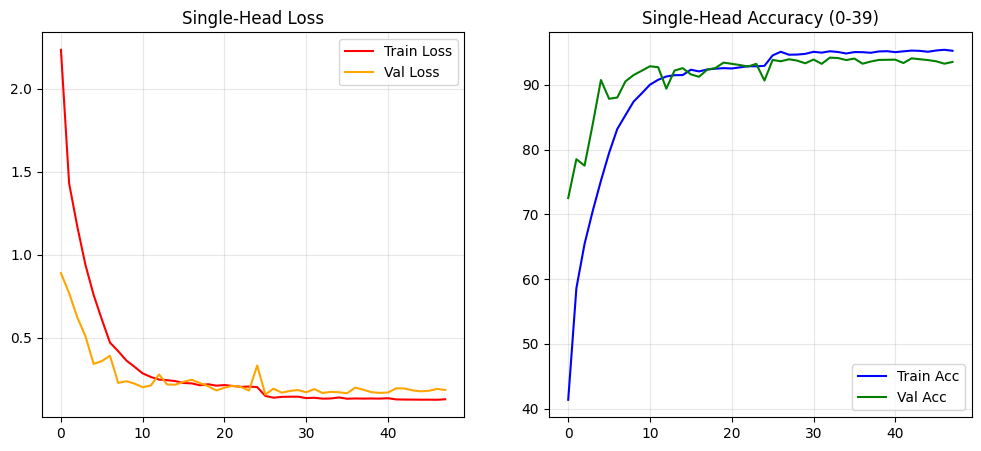

In [7]:
# 6. PLOTTING METRICS
# -------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(metrics['train_loss'], label='Train Loss', color='red')
plt.plot(metrics['val_loss'], label='Val Loss', color='orange')
plt.title('Single-Head Loss')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(metrics['train_acc'], label='Train Acc', color='blue')
plt.plot(metrics['val_acc'], label='Val Acc', color='green')
plt.title('Single-Head Accuracy (0-39)')
plt.legend(); plt.grid(True, alpha=0.3)

plt.savefig(os.path.join(OUTPUT_DIR, 'baseline_metrics.png'))
plt.show()



In [9]:
train_loss=metrics['train_loss']
val_loss=metrics['val_loss']
train_acc=metrics['train_acc']
val_acc=metrics['val_acc']

In [10]:
import zipfile

# 8. ZIP ALL RESULTS FOR DOWNLOAD
print("\nZipping results for download...")
results_zip_path = "/kaggle/working/experiment_results.zip"

# Save raw metrics to .npz first
np.savez('/kaggle/working/training_metrics.npz', 
         all_preds=all_preds,all_labels=all_labels,train_loss=train_loss,val_loss=val_loss,
        train_acc=train_acc,val_acc=val_acc)

# Save raw confusion matrices to .npz
np.savez('/kaggle/working/confusion_matrices.npz', cm=cm)

with zipfile.ZipFile(results_zip_path, 'w') as zipf:
    # Add Model
    if os.path.exists(best_model_path):
        zipf.write(best_model_path, arcname='best_oam_model.pth')
    
    # Add Plots
    if os.path.exists('/kaggle/working/metrics_plot.png'):
        zipf.write('/kaggle/working/metrics_plot.png', arcname='metrics_plot.png')
    if os.path.exists('/kaggle/working/confusion_matrices.png'):
        zipf.write('/kaggle/working/confusion_matrices.png', arcname='confusion_matrices.png')
    
    # Add Data
    if os.path.exists('/kaggle/working/training_metrics.npz'):
        zipf.write('/kaggle/working/training_metrics.npz', arcname='training_metrics.npz')
    if os.path.exists('/kaggle/working/confusion_matrices.npz'):
        zipf.write('/kaggle/working/confusion_matrices.npz', arcname='confusion_matrices.npz')

print(f"Done! Download '{results_zip_path}' to save your work.")


Zipping results for download...
Done! Download '/kaggle/working/experiment_results.zip' to save your work.


In [13]:
import numpy as np

# 1. Load the file
# Replace 'training_history.npz' with your actual filename
data = np.load('/kaggle/input/data2comm/experiment_results2/training_metrics.npz')

# 2. See what is inside (List the Keys)
# This tells you the names of the arrays you saved
print("Keys found:", data.files)

Keys found: ['all_preds', 'all_labels', 'train_loss', 'val_loss', 'train_acc', 'val_acc']


✅ Loaded '/kaggle/input/data2comm/experiment_results2/training_metrics.npz'
Loaded 4800 predictions (Classes 0-39).


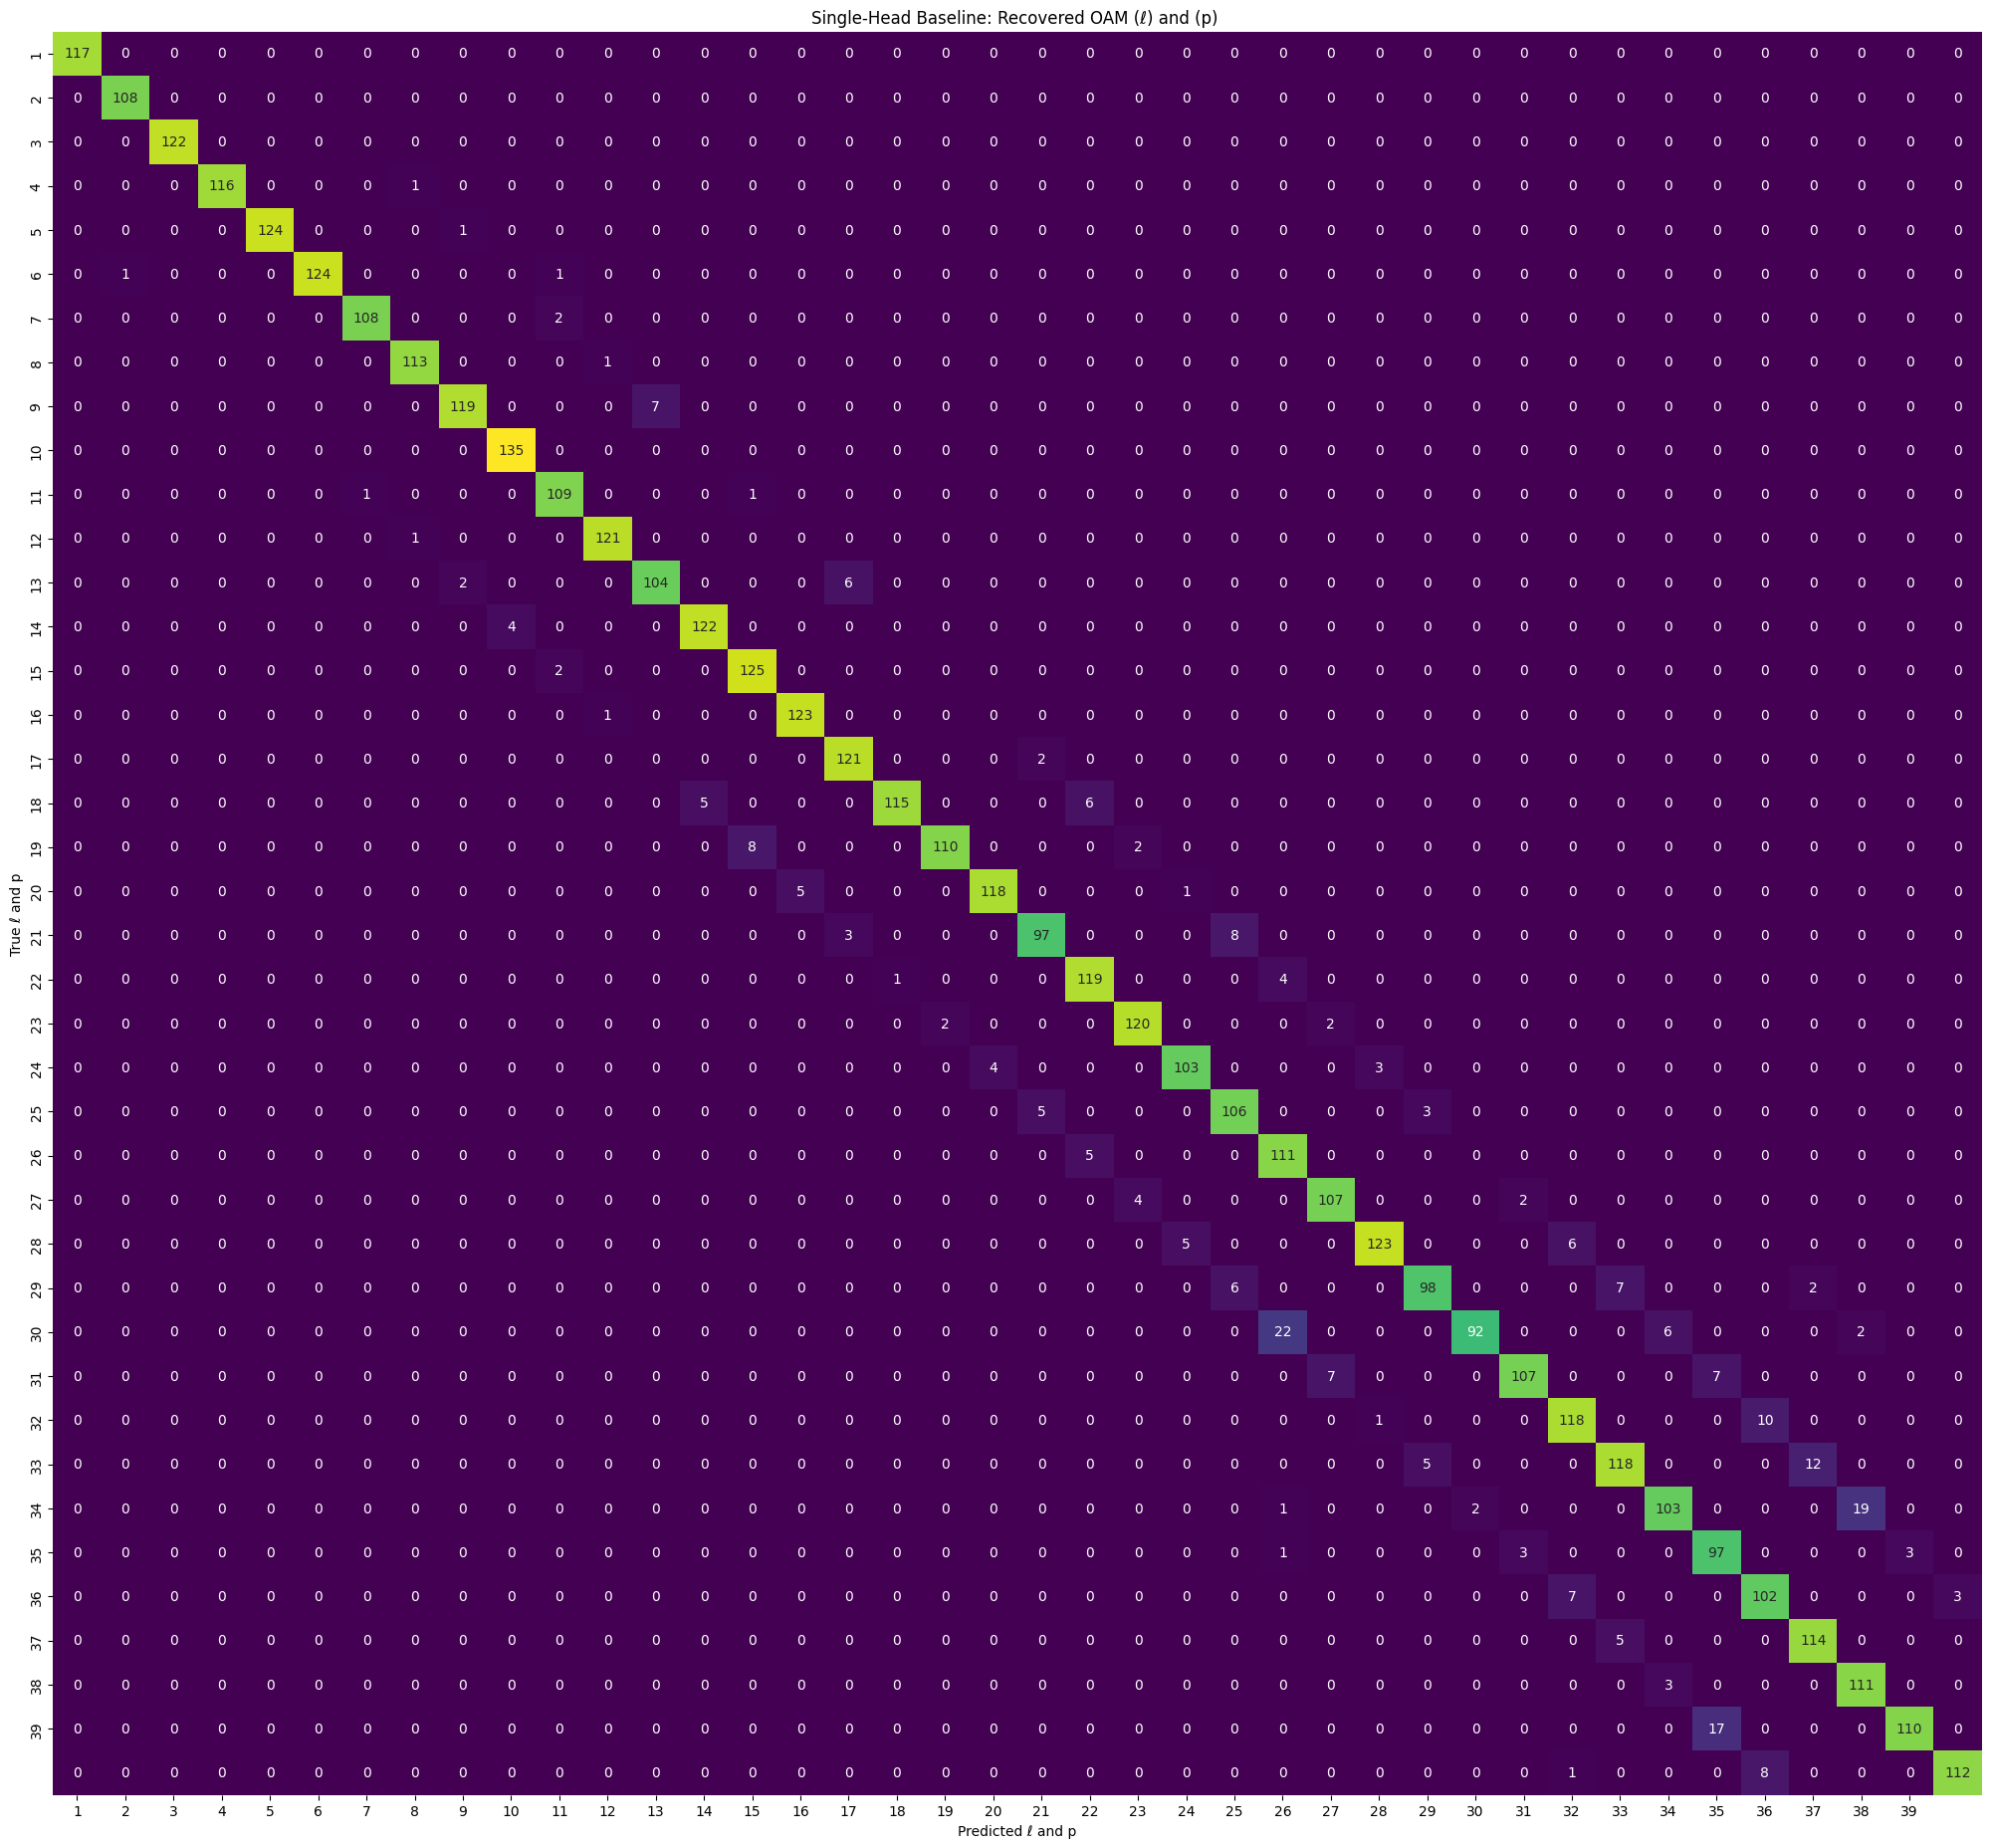

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix

# ================= CONFIGURATION =================
# Path to your Single-Head results
RESULTS_FILE = '/kaggle/input/data2comm/experiment_results2/training_metrics.npz' 

if not os.path.exists(RESULTS_FILE):
    print(f"❌ Error: File '{RESULTS_FILE}' not found.")
else:
    data = np.load(RESULTS_FILE)
    print(f"✅ Loaded '{RESULTS_FILE}'")
    
    # 1. Extract Raw 0-39 Predictions
    if 'all_preds' in data.files and 'all_labels' in data.files:
        raw_preds = data['all_preds']
        raw_labels = data['all_labels']
        print(f"Loaded {len(raw_preds)} predictions (Classes 0-39).")
        
        # 2. Decompose into Physics Indices (L and P)
        # This reverse-engineers the Single-Head logic
        pred = raw_preds 
        true = raw_labels
        
        # 3. Generate Matrices
        cm = confusion_matrix(true, pred, labels=range(40))
        #cm_p = confusion_matrix(true_p, pred_p, labels=range(4))

        # 4. Plot Side-by-Side
        plt.figure(figsize=(25, 23))

        # --- OAM (L) MATRIX ---
        plt.subplot()
        sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False, # Red for Single-Head
                    xticklabels=range(1, 40), yticklabels=range(1, 40))
        plt.title('Single-Head Baseline: Recovered OAM (ℓ) and (p) ')
        plt.xlabel('Predicted ℓ and p')
        plt.ylabel('True ℓ and p')
        
    else:
        print("❌ Error: 'best_preds' or 'best_labels' not found in the .npz file.")
        print("Available keys:", data.files)